# TP4a : Implementation of Long Short-Term Memory (LSTM)

Long Short-Term Memory (LSTM) networks were introduced in 1997 to address, among other things, the problem of vanishing gradient.  LSTM networks resemble classical recurrent networks in which the neurons of the hidden layers are replaced by memory cells. The memory of the $c_t$ cell can be read and modified using **gates**. These gates can be used to learn which data in a sequence is important to keep or discard. Thus, the LSTM network can keep and transmit relevant information throughout a long sequence to make predictions.
In practice, these gates are implemented by layers of fully connected neurons with a sigmoidal activation at the output, which take as input $x_{t}$ and $h_{t-1}$ and weight the values of the $c_t$ cell. A classical LSTM cell has thus:
* an **input gate**, which weights the contribution of the input on the memory at time $t$, 
* a **forget gate**, which allows the network to forget some elements of $c_t$.
* an  **output gate**, which allows to compute the output $h_t$ of the cell according to the input $x_{t}$, $h_{t-1}$ and $c_t$.  

The mechanism is illustrated on the figure below.


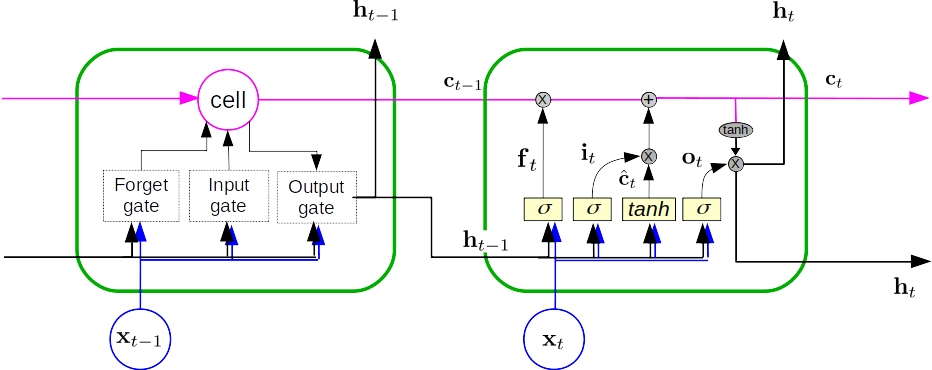


### Forward propagation Equations

If we note:
 * $H$ is the number of hidden neurons, i.e. the size of the vector $\mathbf{h}_t$, which is also that of $\mathbf{c}_t$
 * $N$ the batch size
 * $D_i$ the dimension of each element of a sequence
 * $D_o$ the dimension of each output
 * $L$ the size of a sequence
 

At step $t$ of the sequence, the forward propagation of a batch $\mathbf{x}_t \in \mathbb{R}^{N \times D_i}$, given the previous hidden state $\mathbf{h}_{t-1} \in \mathbb{R}^{N \times H}$ is obtained by the following equations:

$$
\begin{aligned}
\mathbf{i}_t &= \sigma(\mathbf{x}_t \mathbf{W}_{xi} + \mathbf{h}_{t-1} \mathbf{W}_{hi} + \mathbf{b}_i),\\
\mathbf{f}_t &= \sigma(\mathbf{x}_t \mathbf{W}_{xf} + \mathbf{h}_{t-1} \mathbf{W}_{hf} + \mathbf{b}_f),\\
\mathbf{o}_t &= \sigma(\mathbf{x}_t \mathbf{W}_{xo} + \mathbf{h}_{t-1} \mathbf{W}_{ho} + \mathbf{b}_o),\\
\hat{\mathbf{c}}_t &= \text{tanh}(\mathbf{x}_t \mathbf{W}_{xc} + \mathbf{H}_{t-1} \mathbf{W}_{hc} +\mathbf{b}_c),\\
\mathbf{c}_t &= \mathbf{f}_t \odot \mathbf{c}_{t-1} + \mathbf{i}_t \odot \hat{\mathbf{c}}_t,\\
\mathbf{h}_t &= \mathbf{o}_t \odot \tanh(\mathbf{c}_t)
\end{aligned}
$$


where $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo}, \mathbf{W}_{xc} \in \mathbb{R}^{D \times H}$ 
and $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho}, \mathbf{W}_{hc} \in \mathbb{R}^{H \times H}$ are weight matrices, and $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o, \mathbf{b}_c \in \mathbb{R}^{1 \times H}$ are bias parameters.


In [1]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.parameter import Parameter

import matplotlib
import matplotlib.pyplot as plt

torch.manual_seed(0)

## 1. Data generation

We generate here a dummy database, from random numbers. We are indeed only interested in the LSTM modeling for the moment. We will apply it later on to different datasets. This section will obviously have to be adapted to each problem

### Definition of the dimensions of the example


In [2]:
H = 64 # size of the hidden layer
N = 32 # size of the batch
Di = 3 # size of an element of the sequence
Do = 5 # size of the output
L = 10 # size of the sequence

In [3]:
# nomber of sequences in the database:
n_train = 100*N

# generation of random dataset
x_train = torch.randn(size=(n_train,L,Di))
y_train = torch.randn(size=(n_train,Do))
train_dataset = TensorDataset(x_train, y_train)

## 2. Creation and initialization of the parameter tensors

We initialize here the weights matrices according to a Gaussian distribution, and the biases to 0. We recall here the dimensions of the tensors of parameters corresponding to the equations presented above:

* $\mathbf{W}_{xi}, \mathbf{W}_{xf}, \mathbf{W}_{xo}, \mathbf{W}_{xc} \in \mathbb{R}^{D \times H}$ 
* $\mathbf{W}_{hi}, \mathbf{W}_{hf}, \mathbf{W}_{ho}, \mathbf{W}_{hc} \in \mathbb{R}^{H \times H}$ 
* $\mathbf{b}_i, \mathbf{b}_f, \mathbf{b}_o, \mathbf{b}_c \in \mathbb{R}^{1 \times H}$ 


In [4]:
def get_lstm_params(num_inputs, num_hiddens, num_outputs):
    
    def gate_param():
        return (Parameter(torch.randn(num_inputs, num_hiddens, requires_grad=True)),
                Parameter(torch.randn(num_hiddens, num_hiddens, requires_grad=True)),
                Parameter(torch.zeros(num_hiddens, requires_grad=True)))

    # Definition of LSTM parameters
    W_xi, W_hi, b_i = gate_param()  # Input gate parameters
    W_xf, W_hf, b_f = gate_param()  # Forget gate parameters
    W_xo, W_ho, b_o = gate_param()  # Output gate parameters
    W_xc, W_hc, b_c = gate_param()  # Candidate memory cell parameters
    
    # Definition of output layer parameters
    W_hq = torch.randn(num_hiddens, num_outputs, requires_grad=True)
    b_q = torch.zeros(num_outputs, requires_grad=True)
    
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    return params

# Creation of tensors of parameters
weights = get_lstm_params(Di, H, Do)

## 3. Forward propagation Model


In [5]:
def my_lstm(inputs, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (h, c) = (torch.zeros((inputs.shape[0], H)),torch.zeros((inputs.shape[0], H)))
    outputs = []
    for t in range(inputs.shape[1]):
        xt = inputs[:,t,:]        
        i = torch.sigmoid((xt @ W_xi) + (h @ W_hi) + b_i)        
        f = torch.sigmoid((xt @ W_xf) + (h @ W_hf) + b_f)
        o = torch.sigmoid((xt @ W_xo) + (h @ W_ho) + b_o)
        c_hat = torch.tanh((xt @ W_xc) + (h @ W_hc) + b_c)
        c = f * c + i * c_hat
        h = o * torch.tanh(c)
        y = (h @ W_hq) + b_q
    outputs.append(y)
    return torch.cat(outputs, dim=0), (h, c) #cat = concatenate

## 4. Training

Let's train our LSTM:

In [6]:
num_epochs = 30
lr = 0.001

loss_function = nn.MSELoss()
optimizer = optim.Adam(weights, lr = lr)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=N, 
                                           shuffle=True)


In [7]:
# Train the model
losses=[]
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (data, labels) in enumerate(train_loader):
        # Forward pass               
        outputs, (h,c) = my_lstm(data,weights)
        loss = loss_function(outputs, labels)        
        # save
        losses.append(loss.item())         
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/30], Step [20/100], Loss: 10.8140
Epoch [1/30], Step [40/100], Loss: 10.6340
Epoch [1/30], Step [60/100], Loss: 8.1136
Epoch [1/30], Step [80/100], Loss: 8.4015
Epoch [1/30], Step [100/100], Loss: 8.5461
Epoch [2/30], Step [20/100], Loss: 8.8761
Epoch [2/30], Step [40/100], Loss: 7.7486
Epoch [2/30], Step [60/100], Loss: 7.4795
Epoch [2/30], Step [80/100], Loss: 7.2275
Epoch [2/30], Step [100/100], Loss: 6.9153
Epoch [3/30], Step [20/100], Loss: 7.0968
Epoch [3/30], Step [40/100], Loss: 5.9959
Epoch [3/30], Step [60/100], Loss: 5.5094
Epoch [3/30], Step [80/100], Loss: 4.9977
Epoch [3/30], Step [100/100], Loss: 6.8961
Epoch [4/30], Step [20/100], Loss: 3.7827
Epoch [4/30], Step [40/100], Loss: 5.1004
Epoch [4/30], Step [60/100], Loss: 4.6158
Epoch [4/30], Step [80/100], Loss: 5.2180
Epoch [4/30], Step [100/100], Loss: 4.2010
Epoch [5/30], Step [20/100], Loss: 4.4154
Epoch [5/30], Step [40/100], Loss: 4.5316
Epoch [5/30], Step [60/100], Loss: 4.3332
Epoch [5/30], Step [80/100],

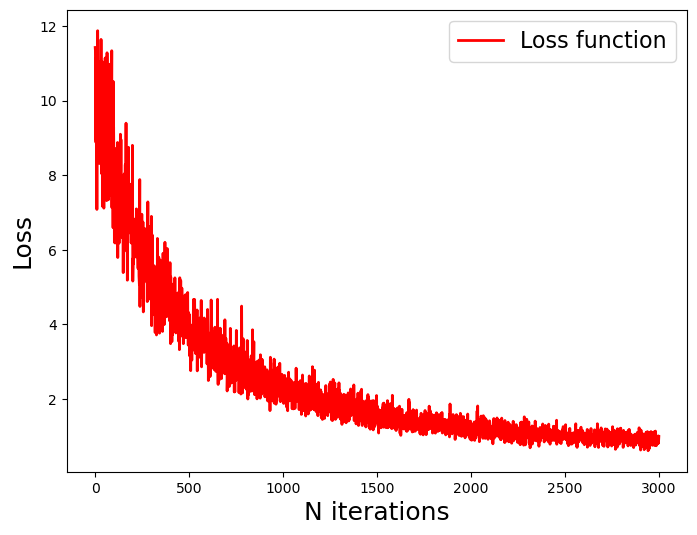

In [8]:
def display(losses,label='Loss function'):
    fig, axes = plt.subplots(figsize=(8,6))
    axes.plot(losses,'r-',lw=2,label=label)
    axes.set_xlabel('N iterations',fontsize=18)
    axes.set_ylabel('Loss',fontsize=18)
    plt.legend(loc='upper right',fontsize=16)

# Display :
display(losses)

## 5. Comparison with pytorch implementation


In pytorch we can create an LSTM layer followed by a fully connected output layer in a simpler way, without having to write the propagation equations ourselves. The tensors are then automatically initialized

In [9]:
# lstm layer
lstm_layer = nn.LSTM(input_size=Di, hidden_size=H, batch_first=True)
# fully connected layer
output_layer = nn.Linear(H,Do)

### To compare both models, we set the same parameters in both

In [10]:
# Creation of test parameter set

test_weights=get_lstm_params(Di, H, Do)
[W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,W_hq, b_q]=test_weights

print("--- pytorch model parameters: ---")
for param_tensor in lstm_layer.state_dict():
    print(param_tensor, "\t", lstm_layer.state_dict()[param_tensor].size())
for param_tensor in output_layer.state_dict():
    print(param_tensor, "\t", output_layer.state_dict()[param_tensor].size())
print()

lstm_layer.weight_ih_l0 = Parameter(torch.cat((W_xi.T,W_xf.T,W_xc.T,W_xo.T), dim=0))
print(lstm_layer.weight_ih_l0.shape)
lstm_layer.weight_hh_l0 = Parameter(torch.cat((W_hi.T,W_hf.T,W_hc.T,W_ho.T), dim=0))
print(lstm_layer.weight_hh_l0.shape)
lstm_layer.bias_ih_l0 = Parameter(torch.cat((b_i,b_f,b_c,b_o), dim=0))
print(lstm_layer.bias_ih_l0.shape)
lstm_layer.bias_hh_l0 = Parameter(torch.zeros(lstm_layer.bias_ih_l0.shape))
print(lstm_layer.bias_hh_l0.shape)
output_layer.weight = Parameter(W_hq.T)
print(output_layer.weight.shape)
output_layer.bias = Parameter(b_q)
print(output_layer.bias.shape)

--- pytorch model parameters: ---
weight_ih_l0 	 torch.Size([256, 3])
weight_hh_l0 	 torch.Size([256, 64])
bias_ih_l0 	 torch.Size([256])
bias_hh_l0 	 torch.Size([256])
weight 	 torch.Size([5, 64])
bias 	 torch.Size([5])

torch.Size([256, 3])
torch.Size([256, 64])
torch.Size([256])
torch.Size([256])
torch.Size([5, 64])
torch.Size([5])


### Comparison of forward propagation with both model

In [11]:
x = x_train[0,:,:]
x = x[None,:,:]
print('x: ',x)

print('------------------------------------')
print('----------- With our model----------')
print('------------------------------------')
# with our implémentation
outputs, (h,c) = my_lstm(x,test_weights)

print('my h: ',h)
print('my c: ',c)
print('my output: ',outputs)


print('-----------------------------------')
print('----------- With pytorch ----------')
print('-----------------------------------')
# with lstm of pytorch
out, (h_n, c_n)=lstm_layer(x)
outputs = output_layer(out[:,-1,:])

print('pytorch h: ',h_n)
print('pytorch c: ',c_n)
print('pytorch output: ',outputs)

x:  tensor([[[-1.1258, -1.1524, -0.2506],
         [-0.4339,  0.8487,  0.6920],
         [-0.3160, -2.1152,  0.3223],
         [-1.2633,  0.3500,  0.3081],
         [ 0.1198,  1.2377,  1.1168],
         [-0.2473, -1.3527, -1.6959],
         [ 0.5667,  0.7935,  0.5988],
         [-1.5551, -0.3414,  1.8530],
         [ 0.7502, -0.5855, -0.1734],
         [ 0.1835,  1.3894,  1.5863]]])
------------------------------------
----------- With our model----------
------------------------------------
my h:  tensor([[-2.9447e-03, -1.0044e-02,  1.6877e-01, -1.5337e-01, -2.0223e-03,
         -7.7808e-01, -1.7922e-01,  4.7999e-01, -1.5218e-01,  1.9470e-01,
          1.2460e-01, -1.8529e-02,  2.7609e-01,  6.3088e-01, -3.3386e-02,
         -3.1760e-01, -2.0681e-01,  3.4226e-01, -1.6573e-02, -5.6372e-02,
          4.2776e-01,  2.7336e-01,  1.1632e-02,  6.2703e-01, -1.9954e-01,
          8.2510e-03,  5.7602e-01, -7.3636e-01, -2.9690e-01,  7.3782e-01,
          1.6212e-01, -1.6504e-01,  6.5437e-01,  2.3